<a href="https://colab.research.google.com/github/pauljune5052-CET/ADALL_github/blob/main/ADALL_Modelling_Evaluation_With_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADALL — Modelling & Evaluation with LLM Support
##**Module:** AI-driven Analytics with Large Language Models (CDA1C03)  
##This notebook continues your learning from "Preparing and Modelling".
##**Focus:**  
What You Will Learn This Week

By the end of this week, you should be able to:

Understand why a single decision tree is often not enough for reliable modelling (Session 1)

Compare Decision Tree, Random Forest, and XGBoost in terms of behaviour and trade-offs (Session 1)

Evaluate models using cross-validation instead of relying on one train-test split (Session 1)

Interpret model performance using stability and variance, not just a single score (Session 1)

Use an LLM to help explain model results and differences in a structured way (Session 2)

Translate model evaluation results into reasoning that supports decision-making (Session 2)

Recognise the limits of predictive models and avoid overclaiming conclusions (Across Sessions 1 & 2)

<<<< Make sure you are using `Table of contents` to visually guide yourself through the notebook.

#Session 1: Beyond Decision Tree

[Expand and collapse section as needed, to prevent it from becoming visually overwhelming.]

In [1]:
# Core libraries
import pandas as pd
import numpy as np
# Visualisation
import matplotlib.pyplot as plt
# Modelling and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Chapter 1. Setup OpenAI API

In [2]:
from google.colab import userdata
from openai import OpenAI
# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(
    api_key=api_key,
)

## Chapter 2. Load Dataset, Preprocessor, Etc

---

## <font color='red'>Note: Why You Are Given Preprocessed Data</font>

To save time, you start from a **prepared train and test split**.
This lets you focus on **modelling and reasoning**, instead of repeating cleaning steps you have already practised earlier.

In the **practical test**, you may be given data that is already prepared in a similar way.
What matters is whether you know **how to use the inputs correctly**, not whether you can rebuild the entire preparation pipeline each time.

---

## <font color='red'>Note: How This Relates to Your Project and Real Practice</font>

For your **project**, this approach helps you manage effort and time.

By preparing your dataset once and saving a clean version, you can:

* Test different models more efficiently
* Experiment with new features without rerunning everything
* Keep your workflow organised and reproducible

This reflects **real industry practice**, where teams store clean, reusable datasets so experimentation can move quickly and reliably.

---


To load the PriceEncoder properly in this notebook, you must redeclare the transformer class first. This allows Python to recognise the object when it is imported.

In [3]:
# ------------------------------------------
# 1. Redefine the PriceEncoder class
#    (must match Notebook from earlier session exactly)
# ------------------------------------------

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class PriceEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_maps, fallback="median"):
        self.column_maps = column_maps
        self.fallback = fallback

    def fit(self, X, y=None):
        self.fallbacks_ = {}
        for col, mapping in self.column_maps.items():
            values = list(mapping.values())
            if self.fallback == "median":
                self.fallbacks_[col] = float(np.median(values))
            else:
                self.fallbacks_[col] = float(self.fallback)
        return self

    def transform(self, X):
        X = X.copy()
        for col, mapping in self.column_maps.items():
            if col not in X.columns:
                continue
            fb = self.fallbacks_[col]
            X[col] = X[col].map(mapping).fillna(fb)
        return X

    def get_feature_names_out(self, input_features=None):
        # return column names after encoding
        return np.array(list(self.column_maps.keys()))


In [4]:
# ------------------------------------------
# 2. Load the preprocessed data
# ------------------------------------------

X_train = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/X_train.csv"
)
X_test = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/X_test.csv"
)
y_train = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/y_train.csv"
    ).squeeze()
y_test = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/y_test.csv"
  ).squeeze()
results = pd.read_csv(
    "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/results.csv"
)

In [5]:
X_test

,Brand,Model,CPU,GPU,RAM_GB,Storage_GB,Touchscreen,Weight_kg,Screen_Size_inch
0,HP,Pavilion 15,Intel i7-14700H,NVIDIA RTX 4060,16,4096,True,1.97,15.6
1,Lenovo,IdeaPad 5,Intel i5-14600H,NVIDIA RTX 4050,8,256,False,1.55,16.0
2,Lenovo,ThinkBook 14s,Intel i9-14900HK,NVIDIA RTX 4070,16,512,False,2.14,15.6
3,Lenovo,ThinkBook 14s,Intel i5-14600H,NVIDIA RTX 4050,16,512,True,2.26,15.6
4,Dell,Inspiron 15,Intel Core Ultra 7 15500H,NVIDIA RTX 4060,16,4096,True,1.31,13.3
...,...,...,...,...,...,...,...,...,...
195,Dell,Inspiron 15,Intel Core Ultra 9 15700H,Intel Arc A750M,8,256,True,1.18,13.3
196,Asus,VivoBook S15,AMD Ryzen 5 8600H,NVIDIA RTX 4050,64,4096,False,1.28,14.0
197,Asus,ROG Zephyrus G15,Intel i7-14700H,NVIDIA RTX 4060,128,2048,False,2.63,17.3
198,HP,Pavilion 15,Intel i7-14700H,NVIDIA RTX 4060,64,512,False,3.09,17.3


In [6]:
import requests
import joblib
# ------------------------------------------
# 3. Load the pickled models
# ------------------------------------------

def load_pickle_from_github(url, local_name=None):
    if local_name is None:
        local_name = url.split("/")[-1]  # default filename

    # download file
    r = requests.get(url)
    if r.status_code != 200:
        raise Exception(f"Download failed with status {r.status_code}")

    # save locally
    with open(local_name, "wb") as f:
        f.write(r.content)

    # load pickle
    return joblib.load(local_name)
url_price_encoder = "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/price_encoder.pkl"
price_encoder = load_pickle_from_github(url_price_encoder)
print("PriceEncoder loaded.")
url_preprocessor = "https://raw.githubusercontent.com/rq-goh/ADALL_github/refs/heads/main/Lab/preprocessor.pkl"

preprocessor = load_pickle_from_github(url_preprocessor)
print("Preprocessor loaded.")


PriceEncoder loaded.
Preprocessor loaded.


In [7]:
results

,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode
0,0,cv_mae_val,154.39454130134254,159.22719202628969
1,1,cv_std_val,18.349529839178974,9.139033241874833
2,2,cv_mae_train,89.55943425197714,89.9223993861607
3,3,cv_std_train,4.139422311001063,3.4700093379095267
4,4,holdout_mae,126.0654432631258,146.702373015873
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg..."


In [8]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 PriceEncoder(column_maps={'Brand': {'Acer': 1300,
                                                                     'Asus': 1800,
                                                                     'Dell': 2000,
                                                                     'HP': 1450,
                                                                     'Lenovo': 1600,
                                                                     'Microsoft': 2200},
                                                           'CPU': {'AMD Ryzen 5 8600H': 1300,
                                                                   'AMD Ryzen 7 8800H': 2300,
                                                                   'AMD Ryzen 9 8900HX': 3200,
                                                                   'Intel Core Ultra 7 15500H': 2600,
                                                                   'Intel Core Ultra 9 15700H': 4200,
                                                                   'Intel i5-14500H': 1400,
                                                                   'Intel i5-14600H': 150...
                                                                     'Spectre x360': 1799,
                                                                     'Surface Book 3': 2899,
                                                                     'Surface Go 3': 649,
                                                                     'Surface Laptop 5': 2499,
                                                                     'Surface Laptop Studio': 3299,
                                                                     'Surface Pro 8': 1399,
                                                                     'Swift 3': 999,
                                                                     'TUF Gaming F15': 1299,
                                                                     'ThinkBook 14s': 1299,
                                                                     'ThinkPad X1 Carbon': 2599,
                                                                     'TravelMate P6': 1500,
                                                                     'VivoBook S15': 899,
                                                                     'XPS 13': 1999,
                                                                     'XPS 15': 3199,
                                                                     'Yoga Slim 7': 1399,
                                                                     'ZenBook 14': 1599}}),
                                 Index(['Brand', 'Model', 'CPU', 'GPU'], dtype='object'))])

In [9]:
price_encoder

PriceEncoder(column_maps={'Brand': {'Acer': 1300, 'Asus': 1800, 'Dell': 2000,
                                    'HP': 1450, 'Lenovo': 1600,
                                    'Microsoft': 2200},
                          'CPU': {'AMD Ryzen 5 8600H': 1300,
                                  'AMD Ryzen 7 8800H': 2300,
                                  'AMD Ryzen 9 8900HX': 3200,
                                  'Intel Core Ultra 7 15500H': 2600,
                                  'Intel Core Ultra 9 15700H': 4200,
                                  'Intel i5-14500H': 1400,
                                  'Intel i5-14600H': 1500,
                                  'Intel i7-14700H': 2200,
                                  'Intel i7-14800H': 2700,
                                  'Intel i9-14900HK'...
                                    'Omen 15': 1899, 'Pavilion 15': 1199,
                                    'Predator Helios 300': 1999,
                                    'ROG Zephyrus G15': 2799,
                                    'Spectre x360': 1799,
                                    'Surface Book 3': 2899, 'Surface Go 3': 649,
                                    'Surface Laptop 5': 2499,
                                    'Surface Laptop Studio': 3299,
                                    'Surface Pro 8': 1399, 'Swift 3': 999,
                                    'TUF Gaming F15': 1299,
                                    'ThinkBook 14s': 1299,
                                    'ThinkPad X1 Carbon': 2599,
                                    'TravelMate P6': 1500, 'VivoBook S15': 899,
                                    'XPS 13': 1999, 'XPS 15': 3199,
                                    'Yoga Slim 7': 1399, 'ZenBook 14': 1599}})

---

## Chapter 3. Train Random Forest and XGBoost

## <font color='red'>Note: Practical Test – Why You Are Running This Modelling Block</font>

This section shows how **two models** can be trained and compared using a **simple grid search** within a single pipeline.

The code is longer because it reflects a **complete workflow**, where different models share the same preprocessing steps.

In a **practical test**, you may be asked to apply a **smaller version of this idea**, such as:

* Setting up a clean pipeline
* Using a short and sensible parameter grid
* Comparing models in a clear and structured way

Practising this structure now helps you recognise the pattern and apply it confidently, even when the task is shorter.

---

## <font color='red'>Note: Industry-Style Tasks and Pet Projects – Why This Pattern Matters</font>

For **industry-style tasks** and **pet projects**, this pattern helps you work more efficiently.

Once your pipeline and parameter grids are set up, you can:

* Reuse the same structure to test new models
* Compare ideas without rewriting preprocessing code
* Keep experiments consistent and easier to review

This is a key benefit of using pipelines.
They make your work **cleaner**, **faster**, and **easier to explain** to tutors, reviewers, or stakeholders.


In [10]:
from re import X
# ------------------------------------`
# 0. NOTE: This block takes quite a while to run, do it before moving onto explanation of code
# ------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------
cat_columns = X_train.select_dtypes(include=['object']).columns
num_columns = X_train.select_dtypes(exclude=['object']).columns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
preprocessor_basic = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)],
        remainder='passthrough'
)



pipe_rf = Pipeline([
    ("preprocessor", preprocessor_basic),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor_basic),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
  "regressor__n_estimators": [50],
  'regressor__max_depth':[5,10, None],
  'regressor__criterion':['squared_error', 'absolute_error']
}

param_grid_xgb = {
    "regressor__n_estimators": [50],
  'regressor__max_depth':[2,5,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Random Forest grid search complete.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
XGBoost grid search complete.


## Chapter 4. **How a Decision Tree, Random Forest, and XGBoost Work (Real-Life Example)**

### **Start with a simple real-world situation**

Imagine you are helping a friend decide **which laptop to buy**.

Your friend asks questions like:

1. “Is your budget below $1500?”
2. “Do you need it mainly for typing or gaming?”
3. “Do you care a lot about weight?”

Each question removes some options and narrows the choice.

This is exactly how a **decision tree** works.

A decision tree:

* asks one simple question at a time
* splits choices into smaller groups
* ends with a clear recommendation

---

### **A simple decision tree: choosing a laptop**

```
                          Start
                           |
                 Is your budget < $1500?
                     /                 \
                   Yes                 No
                   |                   |
         Is weight important?     Do you need gaming?
              /      \                /        \
          Yes        No           Yes          No
           |          |            |            |
   Suggest Model A  Model B   Suggest Model C  Model D
```

### **Key idea**

A decision tree is just a **structured way of asking questions** until a decision is made.

This feels natural because it mirrors how people think.

---

## **How a Decision Tree Becomes a Random Forest**

In real life, people give advice differently.

If you ask **five friends** for laptop advice:

* one starts with budget
* another starts with weight
* another focuses on gaming
* another cares about battery life

Each friend forms their **own decision process**.

A **random forest** is:

> **Many decision trees making a decision together and voting on the result.**

### Why this works

| Everyday idea                      | Machine learning meaning      |
| ---------------------------------- | ----------------------------- |
| Sometimes, person can be wrong            | Sometimes, tree/s can overfit          |
| Many opinions average out mistakes | Many trees reduce error       |
| Group decisions are more stable    | Predictions are more reliable |

So instead of trusting one friend, you trust the **majority vote**.

---

## **How Random Forest Becomes XGBoost**

Now imagine a more disciplined approach.

Instead of asking all friends at once:

1. You ask **Friend A** first and note where the advice is wrong.
2. You ask **Friend B** to focus only on fixing A’s mistakes.
3. You ask **Friend C** to fix what A and B still got wrong.
4. This continues step by step.

Each new friend **learns from previous mistakes**.

That is how **XGBoost** works.

### **Key difference**

| Random Forest             | XGBoost                     |
| ------------------------- | --------------------------- |
| Trees built independently | Trees built sequentially    |
| All trees equal           | Later trees focus on errors |
| Many opinions at once     | Continuous improvement      |

XGBoost often performs very well because it:

* learns from mistakes
* improves step by step
* needs fewer trees to be accurate

---



In [11]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# ===== RandomForest (gs_rf) =====
grid_search = gs_rf
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 4) True holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 5) Save into lab book
# -----------------------------------------
results["RandomForest_OHE"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

# ===== XGB (gs_xgb) =====
grid_search = gs_xgb
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

results["XGB_OHE"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

print(cat_columns)
print(num_columns)
print(gs_rf.best_params_)
print(gs_xgb.best_params_)
display(results)


Index(['Brand', 'Model', 'CPU', 'GPU'], dtype='object')
Index(['RAM_GB', 'Storage_GB', 'Touchscreen', 'Weight_kg', 'Screen_Size_inch'], dtype='object')
{'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__n_estimators': 50}
{'regressor__eval_metric': 'rmse', 'regressor__max_depth': 5, 'regressor__n_estimators': 50}


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_..."


## Chapter 5. Train RF and XGB with LLM Enabled Encoder

In [12]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 PriceEncoder(column_maps={'Brand': {'Acer': 1300,
                                                                     'Asus': 1800,
                                                                     'Dell': 2000,
                                                                     'HP': 1450,
                                                                     'Lenovo': 1600,
                                                                     'Microsoft': 2200},
                                                           'CPU': {'AMD Ryzen 5 8600H': 1300,
                                                                   'AMD Ryzen 7 8800H': 2300,
                                                                   'AMD Ryzen 9 8900HX': 3200,
                                                                   'Intel Core Ultra 7 15500H': 2600,
                                                                   'Intel Core Ultra 9 15700H': 4200,
                                                                   'Intel i5-14500H': 1400,
                                                                   'Intel i5-14600H': 150...
                                                                     'Spectre x360': 1799,
                                                                     'Surface Book 3': 2899,
                                                                     'Surface Go 3': 649,
                                                                     'Surface Laptop 5': 2499,
                                                                     'Surface Laptop Studio': 3299,
                                                                     'Surface Pro 8': 1399,
                                                                     'Swift 3': 999,
                                                                     'TUF Gaming F15': 1299,
                                                                     'ThinkBook 14s': 1299,
                                                                     'ThinkPad X1 Carbon': 2599,
                                                                     'TravelMate P6': 1500,
                                                                     'VivoBook S15': 899,
                                                                     'XPS 13': 1999,
                                                                     'XPS 15': 3199,
                                                                     'Yoga Slim 7': 1399,
                                                                     'ZenBook 14': 1599}}),
                                 Index(['Brand', 'Model', 'CPU', 'GPU'], dtype='object'))])

In [13]:
# ------------------------------------`
# 0. NOTE: This block takes quite a while to run, do it before moving onto explanation of code
# ------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------

pipe_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_rf = {
  "regressor__n_estimators": [200],
  'regressor__max_depth':[5,10, None],
  'regressor__criterion':['squared_error', 'absolute_error']
}

param_grid_xgb = {
    "regressor__n_estimators": [200],
  'regressor__max_depth':[2,4,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_rf.fit(X_train, y_train)
print("Random Forest grid search complete.")

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")



Fitting 10 folds for each of 6 candidates, totalling 60 fits
Random Forest grid search complete.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
XGBoost grid search complete.


## Chapter 6. Evaluate Metrics

In [14]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# ===== RandomForest (gs_rf) =====
grid_search = gs_rf
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 4) True holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 5) Save into lab book (6 rows)
# -----------------------------------------
results["RandomForest_llm_encode"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

# ===== XGB (gs_xgb) =====
grid_search = gs_xgb
best_model = grid_search.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())
cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

results["XGB_llm_encode"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    grid_search.best_params_,
]

display(results)


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE,RandomForest_llm_encode,XGB_llm_encode
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634,127.75609,57.395349
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606,8.379194,3.006915
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442,48.469111,38.433422
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778,0.715922,1.34553
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116,114.341425,54.419651
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_..."


## **End-of-Lesson Note: Interpreting These Results**

### **How to read this table**

* The metric shown is **cross-validated MAE**.
* The values are **negative** because scikit-learn returns *negative loss* for MAE.
* **Closer to zero is better**.
  For example, −134 is better than −235.

There are two key parts to compare:

* **cv_mae_test**: how well the model generalises
* **cv_mae_train**: how well the model fits the training data

---

### **What the results are telling you**

1. **Single decision trees perform worst**

   * Both baseline DTR models have:

     * large test error
     * large train–test gap
   * This is classic **overfitting**.
   * One tree is too unstable to rely on.

2. **Ensembles are clearly better**

   * Random Forest and XGBoost both reduce test MAE substantially.
   * This confirms why we moved beyond single trees earlier in the lesson.

3. **XGBoost gives the best overall performance**

   * `XGB_OHE` has the **lowest test MAE**.
   * It also has a **smaller train–test gap**, which indicates better generalisation.
   * This matches the theory that XGBoost learns by **correcting earlier mistakes**.

4. **Encoding choice still matters**

   * OHE and LLM encoding change performance.
   * There is no universal “best encoding”.
   * This reinforces that **feature representation is part of modelling**, not a separate step.

---

### **Important stability check**

Look at **cv_std_test**:

* Lower values mean the model is more stable across splits.
* Tree ensembles reduce variance compared to a single tree.
* This is why they are preferred in practice.

---

### **Link back to concepts from the lesson**

You have now seen the theory reflected in real results:

* Different trees focus on **different features**
  (column sampling in Random Forest and XGBoost)
* Different trees see **different subsets of data**
  (row sampling)
* Random Forest improves stability through averaging
* XGBoost improves accuracy through **sequential correction**

The numbers here are not magic.
They are the outcome of those design choices.

---

### **Key takeaway**

Do not memorise which model “wins”.

Instead, remember this:

> **Better models come from better learning strategies, not from adding complexity blindly.**

In the next lesson, you will move from **overall scores** to **error analysis**, where you examine *which laptops are predicted badly and why*.


#Session 2: Evaluation of model, prediction and its error

In [19]:
#-------------------------------------------
# 1. Create pipeline for XGB model tuning [takes about 5 mins]
# -------------------------------------------

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids for tuning
# -------------------------------------------

# 3 x 3 x 3 x 3 x 2 = 162  combinations
param_grid_xgb = {
"regressor__n_estimators": [600,800,1000],
'regressor__max_depth':[1,3,5],
"regressor__subsample": [0.6, 0.8, 1.0],
"regressor__colsample_bytree": [0.5, 0.7, 1.0],
'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------


gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")
# -------------------------------------------
# 5. Evaluate on test set
# -------------------------------------------
xgb_model = gs_xgb.best_estimator_
xgb_pred = xgb_model.predict(X_test)
print("\nMAE (XGBoost):", mean_absolute_error(y_test, xgb_pred))
print("Best XGB Params:", gs_xgb.best_params_)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
XGBoost grid search complete.

MAE (XGBoost): 48.17289836425782
Best XGB Params: {'regressor__colsample_bytree': 0.7, 'regressor__eval_metric': 'rmse', 'regressor__max_depth': 1, 'regressor__n_estimators': 1000, 'regressor__subsample': 1.0}


In [18]:
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# -----------------------------------------
# 1) CV diagnostics on TRAIN only
#    cross_validate gives train_score and test_score
# -----------------------------------------
best_model = gs_xgb.best_estimator_

cv_out = cross_validate(
    best_model,
    X_train, y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise"
)

# Convert negative MAE to positive MAE
val_mae_scores = -cv_out["test_score"]
train_mae_scores = -cv_out["train_score"]

cv_mae_val_mean = float(val_mae_scores.mean())
cv_mae_val_std  = float(val_mae_scores.std())

cv_mae_train_mean = float(train_mae_scores.mean())
cv_mae_train_std  = float(train_mae_scores.std())

# -----------------------------------------
# 2) Holdout MAE (fit once, evaluate once)
# -----------------------------------------
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
holdout_mae = float(np.mean(np.abs(y_test - y_pred)))

# -----------------------------------------
# 3) Save into results (same 6-row lab book)
# -----------------------------------------
results["XGB_llm_encode_tuned"] = [
    cv_mae_val_mean,
    cv_mae_val_std,
    cv_mae_train_mean,
    cv_mae_train_std,
    holdout_mae,
    gs_xgb.best_params_,
]

display(results)


,Unnamed: 0,0,Baseline_DTR_MAE,DTR_llm_encode,RandomForest_OHE,XGB_OHE,RandomForest_llm_encode,XGB_llm_encode,XGB_llm_encode_tuned
0,0,cv_mae_val,154.39454130134254,159.22719202628969,105.544566,72.930634,127.75609,57.395349,47.501969
1,1,cv_std_val,18.349529839178974,9.139033241874833,5.708422,5.91606,8.379194,3.006915,1.588689
2,2,cv_mae_train,89.55943425197714,89.9223993861607,40.375061,20.298442,48.469111,38.433422,42.178445
3,3,cv_std_train,4.139422311001063,3.4700093379095267,0.779084,0.877778,0.715922,1.34553,0.639776
4,4,holdout_mae,126.0654432631258,146.702373015873,83.057219,65.239116,114.341425,54.419651,48.172898
5,5,best para,"{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__criterion': 'squared_error', 'reg...","{'regressor__eval_metric': 'rmse', 'regressor_...","{'regressor__colsample_bytree': 0.7, 'regresso..."


✅ Technical Summary of Key Terms and What They Mean
1. Regularisation

Regularisation means adding constraints that stop a model from becoming too complex.
In tree models like XGBoost, regularisation includes:

Method	What it prevents
max_depth	trees becoming too deep and memorising noise
subsample	model relying too much on specific rows
colsample_bytree	model relying too much on specific features
learning rate	large jumps that cause overfit

You use regularisation when your model learns the training data “too well” and performs worse on unseen data.

2. Bias–Variance Trade-off

Machine learning models must balance:

Term	Meaning
Bias	how wrong the model is because it is too simple
Variance	how unstable the model is across different samples

Deep trees → low bias, high variance
Shallow boosting → slightly higher bias, much lower variance

Your tuned XGBoost model reduces variance strongly, which is why CV scores become stable.

3. Cross-validation (CV) MAE

How to read the scores quickly

If cv_train is much higher than cv_val The model fits the training data very well but does not generalise as well. This suggests overfitting. The model may be too complex or relying on noise.

If cv_train and cv_val are both low The model cannot fit the training data properly. This suggests underfitting. The model or features are too simple for the task.

If cv_val and holdout_r2 are similar Your validation process is giving a realistic estimate of real-world performance. This means your modelling and evaluation setup is reliable.

## **Continuing on XGB: Column Sampling and Subsampling (Same Laptop Example)**

Now let us explain **sampling**, which is critical for Random Forest and XGBoost.

### **Flag upfront**

This explanation depends on perspective:

* Conceptually: it is about **limiting information**
* Practically: it is about **reducing overfitting and speed**

Both views are valid.

---

## **Subsampling (Row Sampling)**

### **Standard definition**

Subsampling means **each tree is trained using only a subset of the rows (data points)** instead of the full dataset.

This is standard in Random Forest and optional but common in XGBoost.

---

### **Real-life analogy: not asking everyone**

You have **1,000 laptop buyers** with past purchase data.

Instead of asking all 1,000 people every time:

* Friend A looks at **300 buyers**
* Friend B looks at **another 300**
* Friend C looks at a different 300

Each friend sees **different people**, not the full crowd.

### **Why this helps**

* Each tree learns slightly different patterns
* Trees become less similar to each other
* **Mistakes from one group do not dominate**

---

## **Column Sampling (Feature Sampling)**

### **Standard definition**

Column sampling means **each tree considers only a subset of features (columns)** when making splits.

Instead of using all features every time, the model uses only some.

---

### **Real-life analogy: limited attention**

A laptop has many features:

* price
* weight
* CPU
* GPU
* battery life
* screen size
* brand

Now imagine:

* Friend A only looks at **price, weight, battery**
* Friend B only looks at **CPU, GPU**
* Friend C only looks at **brand and screen size**

Each friend ignores some information.

This is **column sampling**.

---

## **Why column sampling matters**

| Real life                          | Machine learning                  |
| ---------------------------------- | --------------------------------- |
| People focus on different criteria | Trees focus on different features |
| No single opinion dominates        | No single feature dominates       |
| More diverse advice                | Better generalisation             |

---

## **Putting Both Together**

| Concept         | Real-life meaning                   | Model effect        |
| --------------- | ----------------------------------- | ------------------- |
| Subsampling     | Asking different groups of people   | Reduces overfitting |
| Column sampling | Friends focus on different criteria | Increases diversity |
| Both combined   | More balanced advice                | More robust models  |

---

## **Edge cases and caveats**

* If you sample **too little data**, trees become weak.
* If you sample **too few features**, trees may miss important signals.
* XGBoost allows you to **control how aggressive sampling is**.
* Decision trees alone do **not** usually sample rows or columns.

---



---

## **Clarification: this is not unique to XGBoost**

Before moving on, it is important to be clear about one point.

**Random Forest already does row sampling and column sampling.**

That is why, in the earlier example:

* different friends looked at **different buyers** (row sampling)
* different friends preferred **different laptop features** such as price, weight, or GPU (column sampling)

So when you see:

* one tree focusing on *price and weight*
* another focusing on *CPU and GPU*
* another focusing on *brand and battery*

this behaviour **already exists in Random Forest**.

This happens because Random Forest:

* bootstraps rows (different subsets of people)
* samples features at each split (different predictors allowed)

---

## **What XGBoost adds on top**

XGBoost does **not introduce sampling**.

Instead, it adds **structure and control**:

| What already exists                    | What XGBoost adds                        |
| -------------------------------------- | ---------------------------------------- |
| Different trees see different rows     | Explicit subsample ratios                |
| Different trees use different features | Column sampling at tree, level, or split |
| Trees already diverse                  | Trees trained to fix earlier mistakes    |

Using the same analogy:

* Random Forest is **many friends giving independent advice**, each with their own preferences.
* XGBoost is a **coached team**, where later friends are told:
  “Focus on the mistakes made earlier.”

---

## **Key exam-safe takeaway**

* If you say “Random Forest also does column and row sampling”, you are **correct**.
* If you say “XGBoost improves on this by learning sequentially”, you are **also correct**.
* The defining difference is **how trees learn**, not whether they sample.

This wording avoids a very common student misconception and aligns with how these models are actually implemented.



## **Final intuition**

* Decision Tree: one person, full attention, full data
* Random Forest: many people, different people, different views
* XGBoost: structured improvement, learning from mistakes
* Sampling: deliberately limiting information to improve reliability

This is why modern tree-based models work so well in practice.

---

## <font color='red'>Note: Practical Test – Why You Are Reading These XGBoost Sections</font>

This section is meant to help you **build intuition**, not memorise definitions.

Tree-based models appear in the **lab**, the **practical test**, and later in your work.
The explanation here is to give you a **mental picture** of how these models behave.

In a **practical test**, you may be asked to:

* Choose between a decision tree, random forest, or XGBoost
* Explain in simple terms why one model is more stable or accurate than another

You are **not expected** to repeat this explanation word for word.
What matters is that you understand the **ideas behind the models**.

---

## <font color='red'>Note: Industry-Style Tasks and Pet Projects – Why This Intuition Matters</font>

For **industry-style tasks** and **pet projects**, this intuition helps you make and defend modelling choices.

It allows you to:

* Justify why a particular model is suitable for the problem
* Explain results clearly to others
* Discuss trade-offs without going into technical detail

Being able to describe how a model works in **everyday language** is often more important than knowing every parameter.



## Chapter 7. Visual Evaluation — Actual vs Predicted Line Plot (XGB)

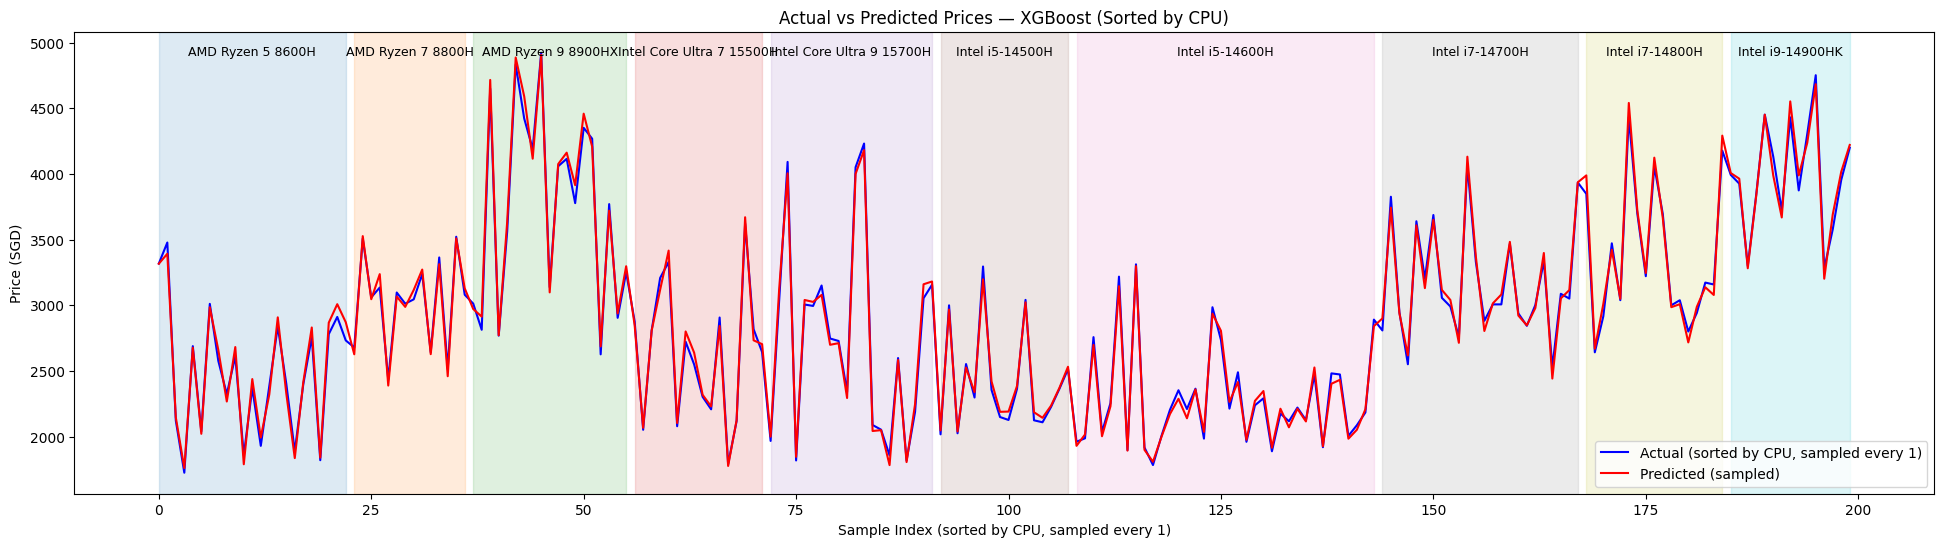

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# USER SETTINGS (edit these only)
# -----------------------------------------
sort_col = "CPU"   # any column in X_test (e.g. "Brand", "GPU", "Screen_Size_inch")
step_n  = 1         # sample every n-th row after sorting

# -----------------------------------------
# 1. Sort by chosen column
# -----------------------------------------
sorted_idx = X_test[sort_col].sort_values().index

X_sorted = X_test.loc[sorted_idx]
y_sorted = y_test.loc[sorted_idx]

# 🔄 XGBoost prediction instead of RF
y_pred_sorted = gs_xgb.best_estimator_.predict(X_sorted)

# Combine into one DataFrame
df_plot = X_sorted.copy()
df_plot["Actual"] = y_sorted.values
df_plot["Predicted"] = y_pred_sorted

# -----------------------------------------
# 2. Apply sampling with iloc[::step_n]
# -----------------------------------------
df_plot = df_plot.iloc[::step_n].reset_index(drop=True)

group_series = df_plot[sort_col]
unique_groups = group_series.unique()

# colour palette based on unique groups
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))

# Find spans for shading
spans = []
start = 0
for i in range(1, len(group_series)):
    if group_series[i] != group_series[i - 1]:
        spans.append((start, i - 1, group_series[i - 1]))
        start = i
spans.append((start, len(group_series) - 1, group_series.iloc[-1]))

# -----------------------------------------
# 3. Plot with shading + sampled lines
# -----------------------------------------
fig, ax = plt.subplots(figsize=(24, 6))

# Background shading (color spelling is correct)
for idx, (s, e, group_name) in enumerate(spans):
    ax.axvspan(s, e, color=colors[idx % len(colors)], alpha=0.15)

# Actual values
ax.plot(
    df_plot["Actual"].values,
    label=f"Actual (sorted by {sort_col}, sampled every {step_n})",
    color="blue"
)

# Predicted values (XGBoost)
ax.plot(
    df_plot["Predicted"].values,
    label="Predicted (sampled)",
    color="red"
)

ax.set_title(f"Actual vs Predicted Prices — XGBoost (Sorted by {sort_col})")
ax.set_xlabel(f"Sample Index (sorted by {sort_col}, sampled every {step_n})")
ax.set_ylabel("Price (SGD)")
ax.legend()

# Group labels
for idx, (s, e, group_name) in enumerate(spans):
    ax.text(
        (s + e) / 2,
        ax.get_ylim()[1] * 0.98,
        str(group_name),
        ha="center",
        va="top",
        fontsize=9
    )

plt.show()


In [20]:
X_sorted

,Brand,Model,CPU,GPU,RAM_GB,Storage_GB,Touchscreen,Weight_kg,Screen_Size_inch
29,Microsoft,Surface Go 3,AMD Ryzen 5 8600H,AMD Radeon 680M,128,4096,True,1.62,15.6
22,Dell,Inspiron 15,AMD Ryzen 5 8600H,NVIDIA RTX 4050,128,2048,True,3.40,18.4
138,Acer,Predator Helios 300,AMD Ryzen 5 8600H,NVIDIA RTX 3050,16,2048,True,2.58,17.3
28,Microsoft,Surface Go 3,AMD Ryzen 5 8600H,NVIDIA RTX 3050,8,256,False,1.90,15.6
58,Asus,VivoBook S15,AMD Ryzen 5 8600H,NVIDIA RTX 4050,64,1024,False,1.11,14.0
...,...,...,...,...,...,...,...,...,...
100,Lenovo,ThinkBook 14s,Intel i9-14900HK,NVIDIA RTX 4080,64,4096,True,2.49,15.6
164,Microsoft,Surface Pro 8,Intel i9-14900HK,NVIDIA RTX 4070,8,512,False,1.55,16.0
123,Asus,VivoBook S15,Intel i9-14900HK,NVIDIA RTX 4070,64,256,False,2.03,16.0
188,Microsoft,Surface Book 3,Intel i9-14900HK,NVIDIA RTX 4070,32,4096,True,1.04,14.0


---

### How to read this plot (Actual vs Predicted price, sorted by CPU)

### What you are looking at

* The **blue line** is the true laptop price (`y_test`).
* The **red line** is the model’s predicted price (`y_pred`).
* The x-axis is **not time**. It is the sample index **after sorting by CPU type**.
* Each shaded block represents **one CPU category**. Within a block, all laptops use the same CPU model.

This means you are comparing **prediction behaviour within and across CPU groups**, not individual laptops in isolation.

---

## What “good” looks like

* The red line should **track the blue line closely** within each CPU block.
* Small ups and downs are normal. No model predicts perfectly.
* The **gap between red and blue** is the prediction error for each laptop.

---

## Spotting systematic error (bias)

### What to look for

Systematic error appears when the model is **consistently wrong in one direction** within a CPU block:

* Red line mostly **above** blue line → systematic **over-pricing**
* Red line mostly **below** blue line → systematic **under-pricing**

Example patterns you may notice:

* For some **high-end CPUs**, predictions may be consistently lower than actual prices.
* For some **mid-range CPUs**, predictions may cluster too tightly around a fixed value.

### What this tells you

* The model has **learned an average CPU effect**, but not enough **price spread within that CPU**.
* CPU is being treated too strongly as a single signal.

### What to do next

* You can explore as an additional excersie, by adding **interaction features**, e.g. CPU × Brand, CPU × GPU.
* Replace ordinal price maps with:

  * one-hot encoding, or
  * target encoding with proper cross-validation.
* Check whether CPU price maps are **leaking assumptions** instead of letting the model learn.

---

## Spotting random error (noise)

### What to look for

Random error appears as:

* Red and blue lines crossing frequently.
* Errors that change sign from point to point.
* No clear pattern across the whole CPU block.

This usually shows up as **wiggles**, not shifts.

### What this tells you

* The model understands the **general level**, but struggles with:

  * individual configurations,
  * unobserved factors.

### What to do next

* Add features that explain **within-CPU variation**, such as:

  * RAM size,
  * storage type,
  * screen size,
  * promotion or discount flags.
* Accept that some noise is **irreducible**. Not all price variation is explainable by current set of predictors.

---

## Comparing error across CPU blocks

Ask yourself:

* Which CPU blocks show **larger gaps** overall?
* Do high-end CPUs show **larger absolute errors**?
* Does variance increase with price?

If yes:

* Consider evaluating **percentage error**, not just MAE.
* Try **log-transforming price** for training, then invert predictions.

---

## Key takeaway

This plot is not about “is my model good or bad”.
It is about **where and why it fails**.

* **Consistent gaps** → feature design or encoding problem.
* **Random scatter** → missing detail or natural noise.
* **CPU blocks behaving differently** → interactions matter.

This is exactly how you should move from **model accuracy** to **error analysis and feature engineering decisions**.


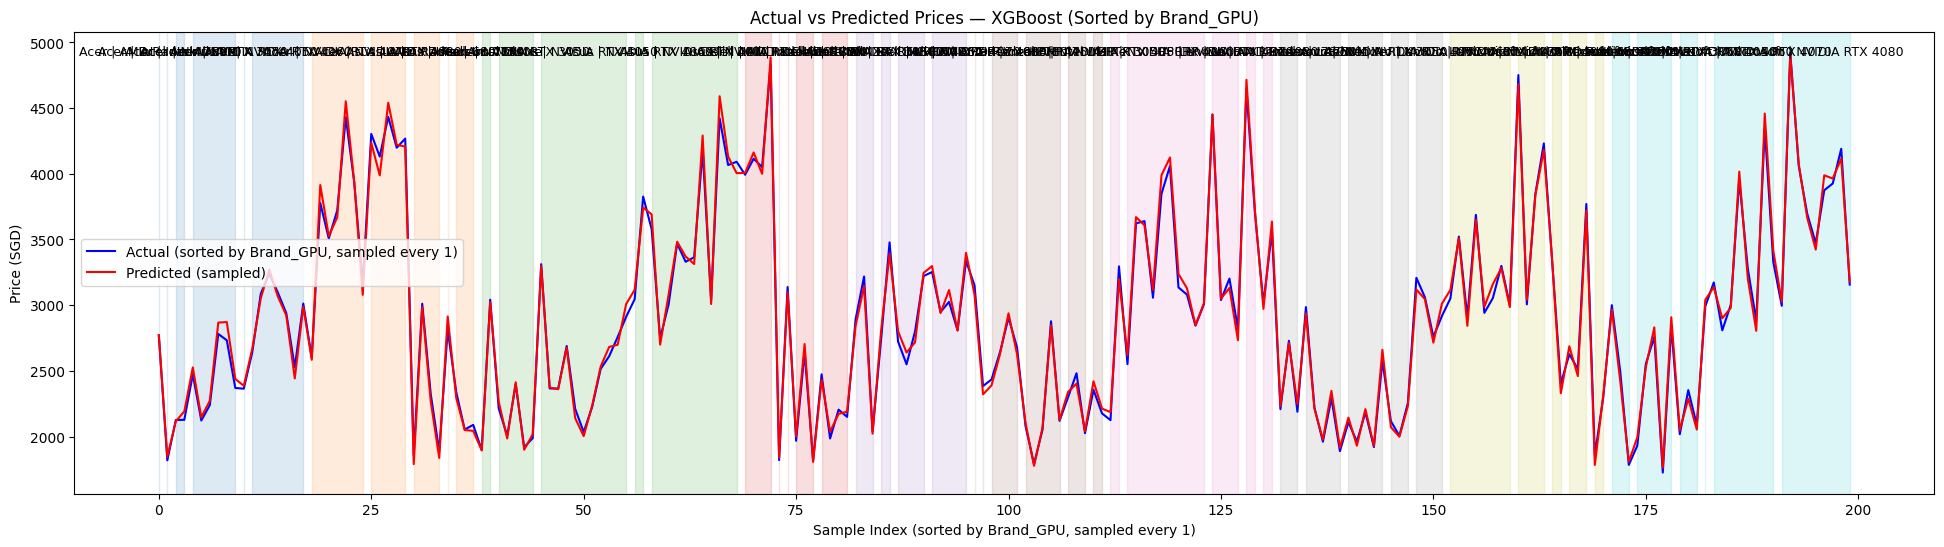

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------
# USER SETTINGS (edit these only)
# -----------------------------------------
# With combination column
X_test["Brand_GPU"] = X_test["Brand"].astype(str) + " | " + X_test["GPU"].astype(str)
X_test = X_test[["Brand_GPU"] + [c for c in X_test.columns if c != "Brand_GPU"]]
sort_col = "Brand_GPU"
#sort_col = "GPU"  # any column in X_test (e.g. "Brand", "GPU", "Screen_Size_inch")
step_n  = 1         # sample every n-th row after sorting

# -----------------------------------------
# 1. Sort by chosen column
# -----------------------------------------
sorted_idx = X_test[sort_col].sort_values().index

X_sorted = X_test.loc[sorted_idx]
y_sorted = y_test.loc[sorted_idx]

# 🔄 XGBoost prediction instead of RF
y_pred_sorted = gs_xgb.best_estimator_.predict(X_sorted)

# Combine into one DataFrame
df_plot = X_sorted.copy()
df_plot["Actual"] = y_sorted.values
df_plot["Predicted"] = y_pred_sorted

# -----------------------------------------
# 2. Apply sampling with iloc[::step_n]
# -----------------------------------------
df_plot = df_plot.iloc[::step_n].reset_index(drop=True)

group_series = df_plot[sort_col]
unique_groups = group_series.unique()

# colour palette based on unique groups
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))

# Find spans for shading
spans = []
start = 0
for i in range(1, len(group_series)):
    if group_series[i] != group_series[i - 1]:
        spans.append((start, i - 1, group_series[i - 1]))
        start = i
spans.append((start, len(group_series) - 1, group_series.iloc[-1]))

# -----------------------------------------
# 3. Plot with shading + sampled lines
# -----------------------------------------
fig, ax = plt.subplots(figsize=(24, 6))

# Background shading (color spelling is correct)
for idx, (s, e, group_name) in enumerate(spans):
    ax.axvspan(s, e, color=colors[idx % len(colors)], alpha=0.15)

# Actual values
ax.plot(
    df_plot["Actual"].values,
    label=f"Actual (sorted by {sort_col}, sampled every {step_n})",
    color="blue"
)

# Predicted values (XGBoost)
ax.plot(
    df_plot["Predicted"].values,
    label="Predicted (sampled)",
    color="red"
)

ax.set_title(f"Actual vs Predicted Prices — XGBoost (Sorted by {sort_col})")
ax.set_xlabel(f"Sample Index (sorted by {sort_col}, sampled every {step_n})")
ax.set_ylabel("Price (SGD)")
ax.legend()

# Group labels
for idx, (s, e, group_name) in enumerate(spans):
    ax.text(
        (s + e) / 2,
        ax.get_ylim()[1] * 0.98,
        str(group_name),
        ha="center",
        va="top",
        fontsize=9
    )

plt.show()


## Chapter 8. Scatter Plot — Actual vs Predicted with Brand Colours

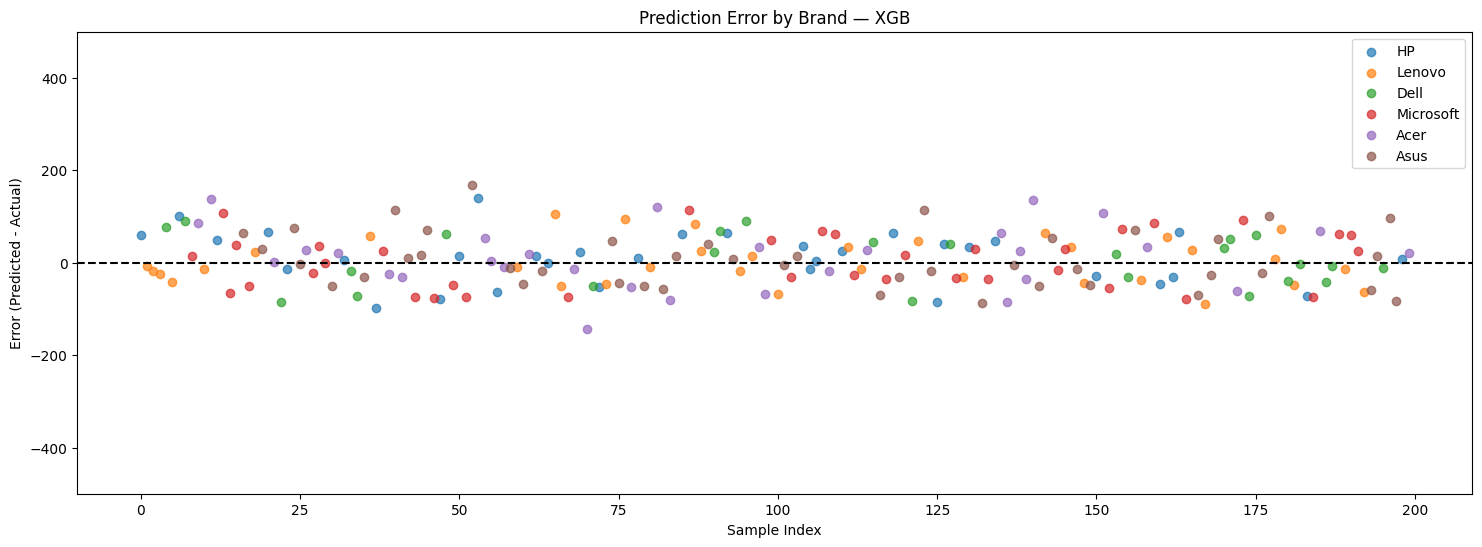

In [25]:
test_df=X_test.copy()
test_df['Actual']=y_test.values
test_df['Pred_XGB']=gs_xgb.best_estimator_.predict(X_test)
test_df['Error']=test_df['Pred_XGB']-test_df['Actual']
test_df['Brand']=X_test.loc[test_df.index,'Brand']

plt.figure(figsize=(18,6))
for b in test_df['Brand'].unique():
    sb=test_df[test_df['Brand']==b]
    plt.scatter(sb.index,sb['Error'],label=b,alpha=0.7)
plt.axhline(0,color="black",linestyle="--")
plt.title("Prediction Error by Brand — XGB")
plt.xlabel("Sample Index")
plt.ylabel("Error (Predicted - Actual)")
plt.ylim(-500,500)
plt.legend()
plt.show()


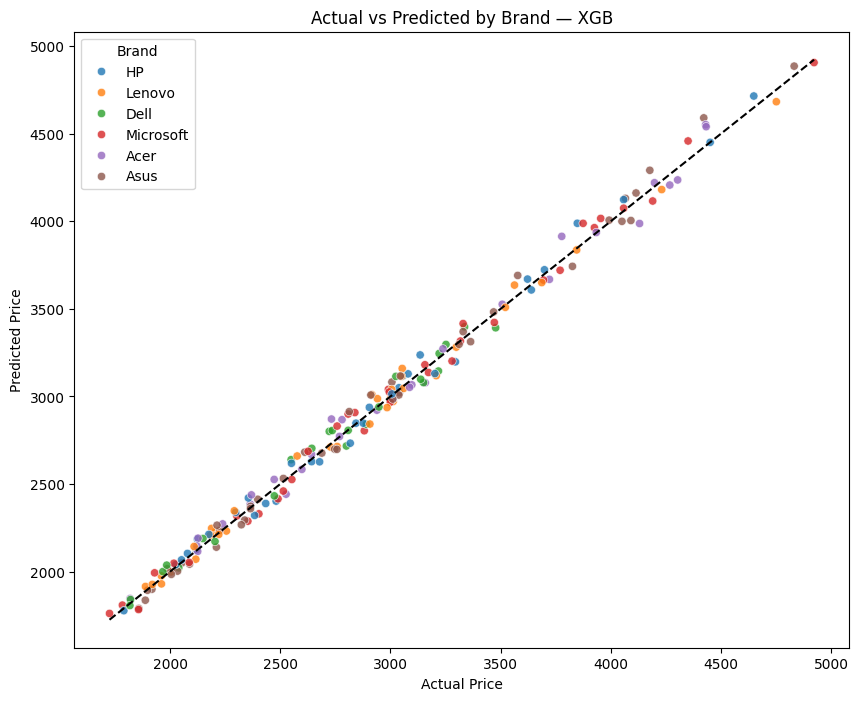

In [27]:
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.figure(figsize=(10,8))
sns.scatterplot(x=test_df['Actual'],y=test_df['Pred_XGB'],hue=test_df['Brand'],alpha=0.8)
plt.plot([test_df['Actual'].min(),test_df['Actual'].max()],
         [test_df['Actual'].min(),test_df['Actual'].max()],
         '--',color='black')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted by Brand — XGB")
plt.show()


* **Chart A (top):** *Prediction deviation by brand — XGB*
* **Chart B (bottom):** *Actual vs Predicted by brand — XGB*

---

### Chart A: Prediction deviation by brand (XGB)

### What it shows

* Y-axis is **Predicted − Actual**.
* The dashed horizontal line is **0**, meaning “no deviation”.

### What to look for (higher value checks)

**1) Brand-level calibration drift (structural bias)**
For each colour (brand), ask:

* Are points mostly above 0? → XGB tends to **over-estimate** that brand.
* Are points mostly below 0? → XGB tends to **under-estimate** that brand.

This is a “brand calibration” issue, not a one-off mistake.

**2) Dispersion (residual variance) by brand**
Look at how tall the cloud is for each brand:

* Tight cloud around 0 → predictions are **stable** for that brand.
* Wide cloud → model is **uncertain** for that brand or missing key features that explain within-brand differences.

**3) Outliers**
Single points far from 0 are “special cases”:

* rare configurations,
* heavy discounts,
* specs not represented well in training.

### What you do with this

* If you see calibration drift: add **brand × CPU** and **brand × GPU** interactions, or use a safer categorical treatment (one-hot or CV target encoding).
* If you see large dispersion: add features that explain **within-brand price spread** (RAM, storage, screen, discount flags), or improve data quality.

---

## Chart B: Actual vs Predicted by brand (XGB)

### What it shows

* Each dot is one laptop.
* The dashed diagonal line is **perfect calibration** (Predicted = Actual).

### What to look for

**1) Calibration quality**

* Dots near the diagonal → well calibrated.
* Dots systematically above/below the diagonal for a brand → matches the drift you saw in Chart A.

**2) Range compression (scale fidelity)**
Check the ends:

* At high actual prices, do predictions fall below the line?
  IF there is, then that is **under-estimation at the top end** (range compression).
* At low actual prices, do predictions rise above the line?
  IF there is, then that is **over-estimation at the low end**.

This usually means the model is “playing safe” and pulling extreme values towards the middle.

### What you do with this

* If you see range compression: try **log(price)** as the target, or tune XGB regularisation and depth to better handle extremes.
* If brands form separate “bands”: brand encoding is dominating, so add interactions or change encoding.

---

## How to use both charts together (the key teaching point)

* **Chart A tells you direction and stability** (who is drifting, who is noisy).
* **Chart B tells you whether the whole price scale is preserved** (are extremes handled well).

If both charts agree that a brand is drifting, that’s strong evidence you need to adjust **feature engineering and encoding**, not just “tune hyperparameters”.

## Chapter 9. Ask LLM to Interpret All Results

###Activity
Draft your own prompt, including all relevant context, to ask for advice on how to improve feature engineering.
A sample solution is provided below. Attempt this on your own first before scrolling down to compare.

In [28]:
df_all = X_test.copy()

df_all["Actual"] = y_test.values
df_all["Predicted"] = xgb_model.predict(X_test)

df_all["Error"] = df_all["Predicted"] - df_all["Actual"]
df_all["Abs_Error"] = df_all["Error"].abs()

summary_rows = []

for col in cat_columns:
    grp = (
        df_all
        .groupby(col)
        .agg(
            actual_mean=("Actual", "mean"),
            actual_std=("Actual", "std"),
            error_mean=("Error", "mean"),
            error_std=("Error", "std"),
            abs_error_mean=("Abs_Error", "mean"),
            abs_error_std=("Abs_Error", "std"),
            count=("Error", "size")
        )
        .reset_index()
    )

    grp.insert(0, "grouping_column", col)
    grp.rename(columns={col: "group_value"}, inplace=True)

    summary_rows.append(grp)
summary_df = pd.concat(summary_rows, ignore_index=True)
summary_df_text = summary_df.to_string()
summary_df


,grouping_column,group_value,actual_mean,actual_std,error_mean,error_std,abs_error_mean,abs_error_std,count
0,Brand,Acer,3097.657667,793.034381,12.363687,67.686261,53.694201,41.917519,30
1,Brand,Asus,2906.755814,813.421574,6.341053,60.228493,48.268390,35.823565,43
2,Brand,Dell,2682.450417,516.353761,6.158729,56.595878,48.970416,27.208557,24
3,Brand,HP,2891.645758,717.922770,10.891552,56.067202,46.157094,32.692649,33
4,Brand,Lenovo,2806.432059,702.743342,3.021371,49.527647,40.851986,27.256854,34
5,Brand,Microsoft,3010.979444,789.515859,3.415077,59.072209,51.688090,27.450502,36
6,Model,Alienware M15,2741.276667,798.855430,-2.334609,61.177361,45.309473,25.911824,3
7,Model,Aspire 5,3408.280000,829.356956,67.809559,85.974822,95.979894,43.068148,6
8,Model,EliteBook 840,3140.405000,791.806700,0.376942,68.609005,60.439009,17.997709,6
9,Model,Envy 13,2658.740000,480.117095,-22.400156,53.885239,33.980866,43.865939,3


In [29]:
summary_df_text

'   grouping_column                group_value  actual_mean   actual_std  error_mean  error_std  abs_error_mean  abs_error_std  count\n0            Brand                       Acer  3097.657667   793.034381   12.363687  67.686261       53.694201      41.917519     30\n1            Brand                       Asus  2906.755814   813.421574    6.341053  60.228493       48.268390      35.823565     43\n2            Brand                       Dell  2682.450417   516.353761    6.158729  56.595878       48.970416      27.208557     24\n3            Brand                         HP  2891.645758   717.922770   10.891552  56.067202       46.157094      32.692649     33\n4            Brand                     Lenovo  2806.432059   702.743342    3.021371  49.527647       40.851986      27.256854     34\n5            Brand                  Microsoft  3010.979444   789.515859    3.415077  59.072209       51.688090      27.450502     36\n6            Model              Alienware M15  2741.276667   

In [30]:
pd.DataFrame(results).T.to_string()

"                                          0                   1                  2                   3                  4                                                                                                                                                                5\nUnnamed: 0                                0                   1                  2                   3                  4                                                                                                                                                                5\n0                                cv_mae_val          cv_std_val       cv_mae_train        cv_std_train        holdout_mae                                                                                                                                                        best para\nBaseline_DTR_MAE         154.39454130134254  18.349529839178974  89.55943425197714   4.139422311001063  126.0654432631258                          

In [31]:
Brand_map={'Acer': 1300, 'HP': 1450, 'Lenovo': 1600, 'Microsoft': 2200, 'Dell': 2000, 'Asus': 1800}
Model_map={'TravelMate P6': 1500, 'Pavilion 15': 1199, 'Legion 5': 1899, 'Envy 13': 1600, 'Surface Laptop 5': 2499, 'Aspire 5': 899, 'Inspiron 15': 899, 'IdeaPad 5': 899, 'Surface Book 3': 2899, 'ThinkBook 14s': 1299, 'ROG Zephyrus G15': 2799, 'Yoga Slim 7': 1399, 'ExpertBook B9': 2399, 'ZenBook 14': 1599, 'Surface Pro 8': 1399, 'Predator Helios 300': 1999, 'Surface Laptop Studio': 3299, 'Nitro 5': 1199, 'Omen 15': 1899, 'Surface Go 3': 649, 'XPS 15': 3199, 'VivoBook S15': 899, 'XPS 13': 1999, 'Swift 3': 999, 'Latitude 7420': 2199, 'TUF Gaming F15': 1299, 'Alienware M15': 3499, 'EliteBook 840': 2199, 'Spectre x360': 1799, 'ThinkPad X1 Carbon': 2599}
CPU_map={'Intel Core Ultra 7 15500H': 2600, 'Intel i5-14600H': 1500, 'Intel i7-14700H': 2200, 'Intel i9-14900HK': 4000, 'Intel i5-14500H': 1400, 'Intel i7-14800H': 2700, 'AMD Ryzen 7 8800H': 2300, 'AMD Ryzen 9 8900HX': 3200, 'AMD Ryzen 5 8600H': 1300, 'Intel Core Ultra 9 15700H': 4200}
GPU_map={'NVIDIA RTX 4070': 2800, 'NVIDIA RTX 4050': 1600, 'NVIDIA RTX 4060': 2100, 'NVIDIA RTX 3050': 1200, 'Intel Arc A750M': 1500, 'Intel Iris Xe': 1100, 'NVIDIA RTX 4080': 3800, 'AMD Radeon 780M': 1200, 'AMD Radeon 680M': 1400}
import json
maps_text = json.dumps(
    {"Brand_map": Brand_map, "Model_map": Model_map, "CPU_map": CPU_map, "GPU_map": GPU_map},
    indent=2,
    ensure_ascii=False
)

In [32]:
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
You are an expert data scientist with extensive knowledge of tree-based models.
Use ONLY the information inside the dataset profile text.
Do NOT invent correlations, columns, or values.
If something is not in the dataset profile, state 'Not shown in profile'.
Always justify recommendations using reasoning trace based ONLY on the dataset profile.
""",
    input=f'''
Advise on I can improve my feature engineering and encoding method. \n
Model performance:
{pd.DataFrame(results).T.to_string()} \n
Prediction quality:
{summary_df_text} \n
Current encoding mapping:
{maps_text}
''')

print(response.output_text)


Short summary of what the profile tells us (facts I will use to justify recommendations)
- Best performance so far: XGB with the current "llm_encode" mapping, especially when tuned — XGB_llm_encode_tuned has cv_mae 47.50 and holdout_mae 48.17, vs XGB_OHE cv_mae 72.93 and holdout_mae 65.24. (From the Model performance table.)
- The current categorical->numeric maps (Brand_map, Model_map, CPU_map, GPU_map) contain values that do not match the empirical group target means shown in the Prediction quality table. Example: Brand_map maps "Acer" → 1300 but the table shows Brand "Acer" actual_mean = 3097.66. Similar mismatches exist for GPUs (e.g., GPU_map "AMD Radeon 780M" → 1200 vs actual_mean = 2905.73). (From Current encoding mapping and Prediction quality.)
- Many Model / CPU / GPU group counts are small (several Models with count <= 8, e.g., Alienware M15 count=3, Aspire 5 count=6). Small counts coincide with high error/std in many groups. (From Prediction quality count and error columns.

## 10. End-of-Lesson Summary

In this lesson, you moved beyond **training models** to **evaluating model behaviour** in a structured and meaningful way.

You learned that evaluation is not just a single metric such as MAE or RMSE. Proper evaluation involves:

* **Calibration checking** to see whether predictions are systematically high or low.
* **Segmented evaluation** by brand and price range to uncover hidden biases.
* **Error decomposition** to distinguish persistent misalignment from unexplained variation.
* **Scale fidelity assessment** to verify whether the model preserves low, mid, and high price levels.

Through visual evaluation:

* Error-by-segment plots helped you identify **where** the model deviates.
* Actual vs predicted plots helped you assess **how well** the model tracks reality across the full price range.
* Comparing segments revealed whether issues come from **feature design**, **encoding choices**, or **model constraints**.

The key takeaway is this:
Model evaluation is a **diagnostic process**, not a scoreboard.

Instead of asking *“Which model scores better?”*, you are now evaluating:

* **Who the model works well for**,
* **Where it breaks down**,
* and **what evidence supports your next improvement step**.

This evaluation mindset is essential for building models that are not only accurate, but also **trustworthy, explainable, and fit for real-world decisions**.
